Creation of a baseline IQ constilation plot. 

In [72]:
import numpy as np
import matplotlib.pyplot as plt

num_symbols = 10000

# x_symbols array will contain complex numbers representing the QPSK symbols. Each symbol will be a complex number with a magnitude of 1 and a phase angle corresponding to one of the four QPSK constellation points (45, 135, 225, or 315 degrees)
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))/np.sqrt(2) # AWGN with unity power
r = x_symbols + n * np.sqrt(0.01) # noise power of 0.01
# print(r)
# #plt.plot(np.real(r), np.imag(r), '.')
# plt.grid(True)
# # plt.show()

# Now save to an IQ file
print(type(r[0])) # Check data type.  Oops it's 128 not 64!
r = r.astype(np.complex64) # Convert to 64
print(type(r[0])) # Verify it's 64
r.tofile('qpsk_in_noise.iq') # Save to file

<class 'numpy.complex128'>
<class 'numpy.complex64'>


Example ML Methods on IQ based Cluster Plots

[-0.69193196+0.6915725j  -0.5226531 +0.68684465j -0.72824055-0.5682129j
 ...  0.7675917 +0.6472227j  -0.8046967 +0.716002j
  0.6938118 +0.59726435j]


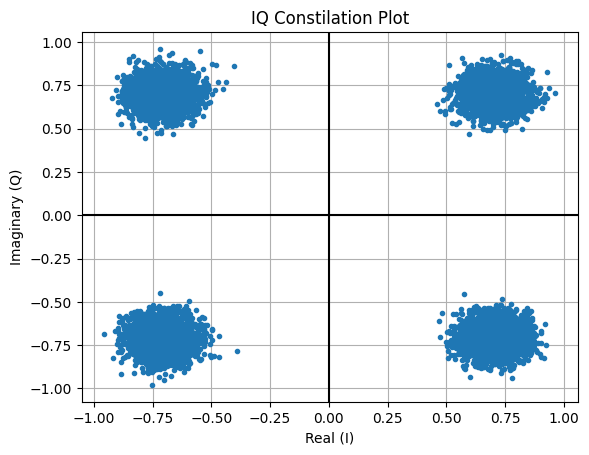

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

samples = np.fromfile('qpsk_in_noise.iq', np.complex64) # Read in file.  We have to tell it what format it is
print(samples)

# Plot constellation to make sure it looks right
plt.plot(np.real(samples), np.imag(samples), '.')
plt.grid(True)
plt.title("IQ Constilation Plot")
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.xlabel("Real (I)")
plt.ylabel("Imaginary (Q)")
plt.show()

In [66]:
#Creating a two dimenion numpy arry with all real numbers so that it can be used for k-means clustering and fitting. 
I = np.real(samples)
Q = np.imag(samples)
IQ = np.stack((I, Q), axis=1)
IQ

array([[-0.69193196,  0.6915725 ],
       [-0.5226531 ,  0.68684465],
       [-0.72824055, -0.5682129 ],
       ...,
       [ 0.7675917 ,  0.6472227 ],
       [-0.8046967 ,  0.716002  ],
       [ 0.6938118 ,  0.59726435]], shape=(10000, 2), dtype=float32)

In [67]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(IQ)
    
    distortions.append(sum(np.min(cdist(IQ, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / IQ.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

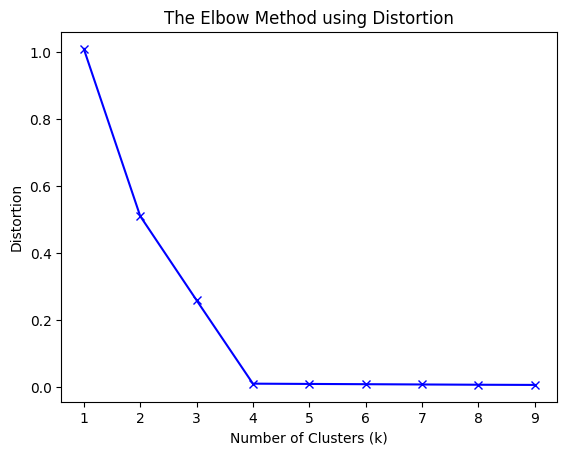

In [68]:
# Showing the elbow method with a clear drop off in determisitic clusters. 
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Creation of elbow method threashold
threashold = 0.1
x = 0 
for number in distortions:
    if number >= threashold:
        x += 1
    else:
        pass
threashold_breakpint = x + 1

Using the threashold based analysis and elbow method to determine the number of clusters for the an IQ contilation. This is an example of applying machine learning via the K means method and the identified number of cluters to the IQ plot values after conversion from imaginary numbers (IQ) to real numbers in a 2D numpy arry. 

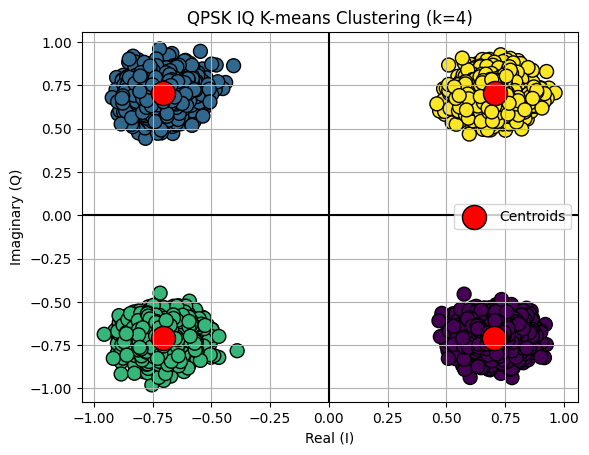

In [56]:
kmeans = KMeans(n_clusters=threashold_breakpint, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(IQ)

plt.scatter(IQ[:, 0], IQ[:, 1], c=y_kmeans, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=300, c='red', label='Centroids', edgecolor='k')
plt.title(f'QPSK IQ K-means Clustering (k={k})')
plt.xlabel('Real (I)')
plt.ylabel('Imaginary (Q)')
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.legend()
plt.grid()
plt.show()